4/25/19
Pandas on ccs and lima score report csv files
Main goal: combine the two csv files, with the rows (indices) being the ZMW hole numbers

Note: axis 1: horizontal; move across all columns
      axis 0: vertical; move across all rows
      
Recall: ccs parameter descriptions
RG Tag: read group id
np: number of passes
rq: predicted read quality
za: avg Z-score of all subreads successfully added


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
plt.close('all')
#if using remote system: files located at: 
# bam_table.csv: /tier2/deweylab/scratch/ipsc_pacbio/demultiplexing/
#                 demultiplexed_full_bams/baseline/absolute_ccs/2_B01/bam_table.csv
#
#score_report_span_0: /tier2/deweylab/scratch/ipsc_pacbio/demultiplexing/
#     demultiplexed_full_bams/baseline/absolute_ccs/2_B01/lima_baseline/
#     ref_span_0/score_report_span_0
#
#
df_ccs = pd.read_csv('/Users/catherineanderson/Documents/Research_Spring_2019/bam_table.csv')
df_ccs = df_ccs.set_index('ZMW hole number')
#dropping RG Tag because it's just an id
df_ccs = df_ccs.drop('RG Tag', axis=1)


df_lima = pd.read_csv('/Users/catherineanderson/Documents/Research_Spring_2019/score_report_span_0.csv')
df_lima = df_lima.set_index('ZMW hole number')



#df_ccs



In [3]:
#df_lima[['IdxsCombined a', 'IdxsCombined b']]
#df_lima
#df_lima.columns


In [4]:
df_combo = pd.merge(df_ccs,df_lima, on="ZMW hole number")


In [5]:
#takes in a GroupBy's object
#returns the number of zmws correctly barcoded
def correct_count (gb):
    count_dict = {}
    for name, group in gb:
        count = 0
  #      print ("name:", name)
  #      print ("group:")
  #      print(group)
        for row_index, row_data in group.iterrows():
 #           print("row_index: ",row_index)
  #          print("row_data: ")
  #          print(row_data)
            first_id = row_data['IdxsCombinedA']
            second_id = row_data['IdxsCombinedB']
  #          print("first id:",first_id)
  #          print("second id:",second_id)
   #     print()
        
            if(first_id == 3):
                if(second_id == 0):
                    count += 1
            elif(first_id == 0):
                if(second_id == 3):
                    count += 1
        count_dict[name] = count
 #   print("count_dict: ",count_dict)
    return count_dict;
        
        


In [6]:
#takes in a GroupBy object 
#returns the (decimal) percent correctly barcoded
def percent_correct(gb):
    correct_count_dict = correct_count(gb)
    group_sizes_dict = gb.size()
    percent_correct_dict = {}
    for name, group in gb:
        percent_correct_dict[name] = correct_count_dict[name]/group_sizes_dict[name]
    return percent_correct_dict
    

In [145]:
#calculates cumulative count correct
#given groupby object "gb" and an "ascend" value 
#    (true if want cumulative of value plus all higher ie want to find min, 
#     false if want cumulative of value plus all lower ie want to find max) 
def cumulative_count_correct(ascend,gb):
    count = 0
    count_dict = {}
    if ascend == False: #correct count is count of current plus count of all lower
        for name, group in gb:
            #print ("np (name):", name)
        
            for row_index, row_data in group.iterrows():
                first_id = row_data['IdxsCombinedA']
                second_id = row_data['IdxsCombinedB']
   #             print("first_id:",first_id)
    #            print("second_id:",second_id)
                if(first_id == 3):
                    if(second_id == 0):
                        count += 1
                elif(first_id == 0):
                    if(second_id == 3):
                        count += 1
            count_dict[name] = count
    else: #correct count is count of current plus count of all greater
        noncumulative_count_dict = correct_count(gb)
        sorted_dict_keys = sorted(noncumulative_count_dict.keys(),reverse=True)
        count_dict[sorted_dict_keys[0]] = noncumulative_count_dict[sorted_dict_keys[0]]
        #print(sorted_dict_keys)
        for num in np.arange(1,len(sorted_dict_keys)):
            count_dict[sorted_dict_keys[num]] = count_dict[sorted_dict_keys[num-1]] + noncumulative_count_dict[sorted_dict_keys[num]]
                
        #print("non_cumulative_count_dict:")
        #print(noncumulative_count_dict)
        #print("cumulative_count_dict")
        #print(count_dict)
        
    return count_dict
        

In [148]:
#calculates cumulative percent correct
#given groupby object "gb" and an "ascend" value 
#    (true if want cumulative of value plus all higher ie want to find min, 
#     false if want cumulative of value plus all lower ie want to find max) 
def cumulative_percent_correct(ascend,gb):
    correct_count_dict = cumulative_count_correct(ascend,gb)
    #print("correct_count_dict",correct_count_dict)
    noncumulative_group_sizes_dict = gb.size()
    cumulative_group_sizes_dict = {}
    percent_correct_dict = {}
    sorted_sizes = sorted(noncumulative_group_sizes_dict.keys(),reverse = ascend)
    cumulative_group_sizes_dict[sorted_sizes[0]] = noncumulative_group_sizes_dict[sorted_sizes[0]]
    #print("unsorted noncumulative sizes",noncumulative_group_sizes_dict)
    #print("sorted sizes",sorted_sizes)
    for num in np.arange(1,len(sorted_sizes)):
        cumulative_group_sizes_dict[sorted_sizes[num]] = noncumulative_group_sizes_dict[sorted_sizes[num]] + cumulative_group_sizes_dict[sorted_sizes[num-1]]
            
    #print("cumulative size dict:",cumulative_group_sizes_dict)
        
    for name,group in gb:
        percent_correct_dict[name] = correct_count_dict[name]/cumulative_group_sizes_dict[name]
    #print("percent_correct_dict",percent_correct_dict)
        
    return percent_correct_dict

Let's do CCS first. Parameters to consider: np (number of passes), rq (predicted read quality), za (avg z-score of zmw's successfully added subreads)

# NP

In [151]:
#need to separate out df_combo based on np; 
#if they have same np, they stay in same mini-dataframe

#want to find min np for the --minPasses ccs filter
np_sorted = df_combo.sort_values(by='np')
#np_sorted
np_grouped = df_combo.groupby('np')
#print(np_grouped.groups.keys())
#print (df_combo.head())
#print
np_cumulative_percent_correct_dict = cumulative_percent_correct(True, df_combo.groupby('np'))
#np_cumulative_percent_correct_dict
#np_og_percent_correct_dict = percent_correct(df_combo.head().groupby('np'))
#a = 1
#print(df_combo.head().groupby('np'))
#print(df_combo.head().groupby('np'))

correct_count_dict {314: 0, 296: 2, 287: 3, 283: 4, 281: 5, 278: 7, 277: 8, 272: 9, 263: 10, 260: 11, 252: 12, 248: 13, 242: 14, 240: 15, 239: 16, 237: 17, 235: 18, 233: 20, 231: 22, 226: 23, 221: 25, 213: 26, 211: 30, 210: 31, 205: 32, 202: 33, 200: 33, 199: 34, 197: 35, 196: 37, 195: 38, 194: 39, 191: 40, 188: 42, 187: 43, 186: 44, 185: 45, 184: 46, 182: 48, 181: 50, 180: 52, 179: 53, 176: 56, 175: 57, 173: 61, 172: 62, 171: 64, 170: 67, 169: 70, 168: 73, 167: 74, 166: 75, 165: 78, 164: 83, 163: 85, 162: 88, 161: 89, 160: 95, 159: 98, 158: 103, 157: 105, 156: 106, 155: 108, 154: 117, 153: 121, 152: 123, 151: 134, 150: 138, 149: 143, 148: 147, 147: 151, 146: 158, 145: 162, 144: 168, 143: 174, 142: 184, 141: 190, 140: 192, 139: 200, 138: 205, 137: 212, 136: 220, 135: 231, 134: 240, 133: 247, 132: 256, 131: 265, 130: 273, 129: 288, 128: 300, 127: 315, 126: 325, 125: 342, 124: 360, 123: 378, 122: 390, 121: 402, 120: 416, 119: 434, 118: 443, 117: 456, 116: 471, 115: 492, 114: 513, 113: 53

In [8]:
np_df = pd.DataFrame.from_dict(np_percent_correct_dict, 'index',columns = ['Fraction correct'])

In [9]:
np_df

Fraction correct
1            0.579576
2            0.811020
3            0.900458
4            0.911166
5            0.914694
6            0.919340
7            0.925019
8            0.915297
9            0.921392
10           0.929353
11           0.927232
12           0.926735
13           0.931421
14           0.936549
15           0.925949
16           0.932639
17           0.934271
18           0.935965
19           0.945271
20           0.951740
21           0.940793
22           0.939427
23           0.946009
24           0.950430
25           0.951169
26           0.951238
27           0.951417
28           0.955629
29           0.943950
30           0.956863
..                ...
196          1.000000
197          1.000000
199          1.000000
200          0.000000
202          1.000000
205          1.000000
210          1.000000
211          0.800000
213          1.000000
221          1.000000
226          1.000000
231          1.000000
233          1.000000
235          1.000000
237          1.000000
239          1.000000
240          1.000000
242          1.000000
248          1.000000
252          1.000000
260          1.000000
263          1.000000
272          1.000000
277          1.000000
278          1.000000
281          1.000000
283          1.000000
287          1.000000
296          1.000000
314          0.000000

[217 rows x 1 columns]

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

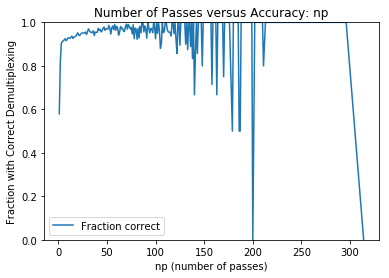

In [10]:
#now try a line plot
plt.figure();
np_ax2 = np_df.plot(title='Number of Passes versus Accuracy: np', use_index = True)
np_ax2.set_xlabel('np (number of passes)')
np_ax2.set_ylim(0, 1)
np_ax2.set_ylabel('Fraction with Correct Demultiplexing')

It looks like an attractive range of high accuracy exists somewhere within the domain between 200 and 330. 

It looks like the domain spanning np=[200,314] has a highly accurate range. HOWEVER we should compare this to a graph of number of zmws vs np value

In [11]:
np_zmw_count =df_combo.groupby('np').size()

In [12]:
np_zmw_df = pd.DataFrame.from_dict(np_zmw_count)


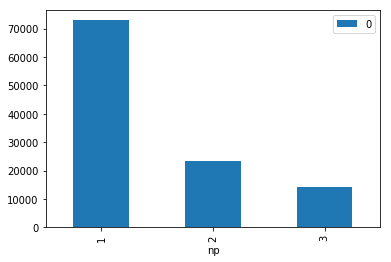

In [109]:
np_zmw_df.loc[0:3].plot(kind='bar')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

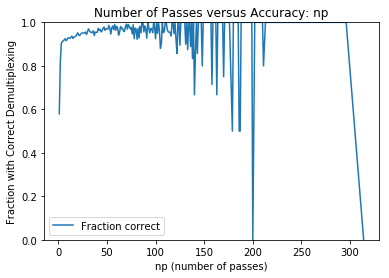

In [14]:
plt.figure();
np_ax2 = np_df.plot(title='Number of Passes versus Accuracy: np', use_index = True)
np_ax2.set_xlabel('np (number of passes)')
np_ax2.set_ylim(0, 1)
np_ax2.set_ylabel('Fraction with Correct Demultiplexing')

It looks like we should stick to the range of np = [0,50], since this is where most of the ZMWs reside. 

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

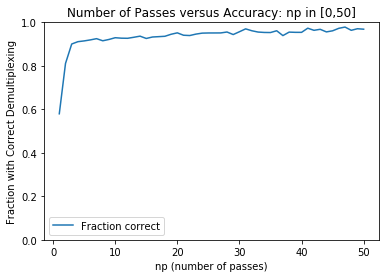

In [15]:
plt.figure();
np_ax2 = np_df.loc[0:50].plot(title='Number of Passes versus Accuracy: np in [0,50]', use_index = True)
np_ax2.set_xlabel('np (number of passes)')
np_ax2.set_ylim(0, 1)
np_ax2.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

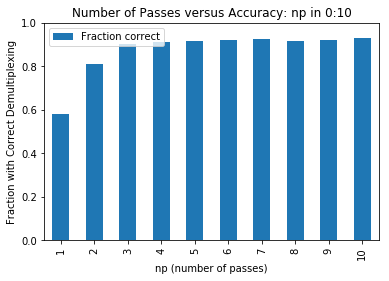

In [16]:
plt.figure();
np_ax2 = np_df.loc[0:10].plot(kind='bar',title='Number of Passes versus Accuracy: np in 0:10', use_index = True)
np_ax2.set_xlabel('np (number of passes)')
np_ax2.set_ylim(0, 1)
np_ax2.set_ylabel('Fraction with Correct Demultiplexing')

# NP Conclusion: 

Based on these graphs, it seems the best range of np values to use is either [2,50] or [3:50] inclusive, depending on what our specific accuracy threshold is. 

# RQ: Read Quality

First: check the distribution of ZMWs over read quality scores

In [17]:
rq_zmw_count =df_combo.groupby('rq').size()

In [18]:
rq_zmw_df = pd.DataFrame.from_dict(rq_zmw_count)

<Figure size 432x288 with 0 Axes>

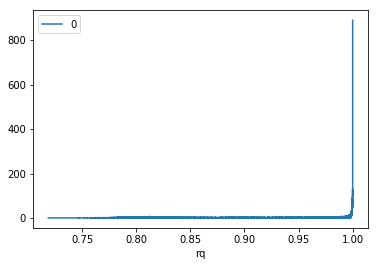

In [19]:
plt.figure()
ax = rq_zmw_df.plot()

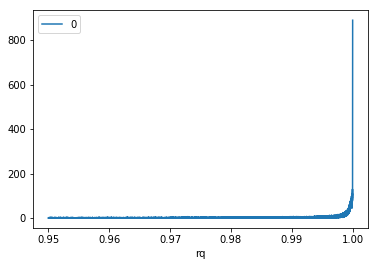

In [20]:
rq_zmw_df.loc[0.95:1].plot()

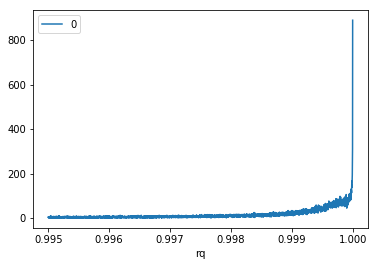

In [21]:
rq_zmw_df.loc[0.995:1].plot()

It looks like almost all ZMWs are clustered between 0.999 and 1.00 (which is great!)

In [22]:
#Separate out based on read quality
rq_percent_correct_dict = percent_correct(df_combo.groupby('rq'))
a = 1

In [23]:
rq_df = pd.DataFrame.from_dict(rq_percent_correct_dict, 'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

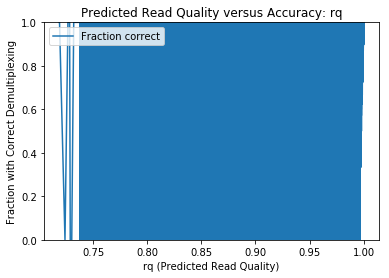

In [24]:
#now try a line graph
plt.figure();
rq_ax = rq_df.plot(title='Predicted Read Quality versus Accuracy: rq')
rq_ax.set_xlabel('rq (Predicted Read Quality)')
rq_ax.set_ylim(0, 1)
rq_ax.set_ylabel('Fraction with Correct Demultiplexing')

graph above: Note that from .77 to .95, the visual is solid blue. this implies that there is much oscillation between high % correct and low. However, somewhere between 0.975 and 1, there is a curve back up to 100% correct. Let's explore that region. 

We already know that nearly all ZMWs are between rq= 0.999 and 1.0, so we might as well just analyze that area


Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

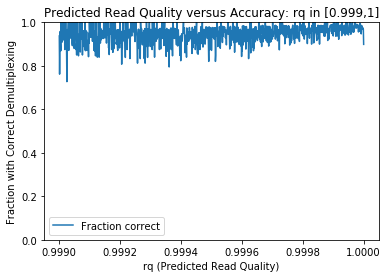

In [25]:
#line graph between 0.999 and 1.00
plt.figure();
rq_ax = rq_df.loc[0.999:1].plot(title='Predicted Read Quality versus Accuracy: rq in [0.999,1]')
rq_ax.set_xlabel('rq (Predicted Read Quality)')
rq_ax.set_ylim(0, 1)
rq_ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

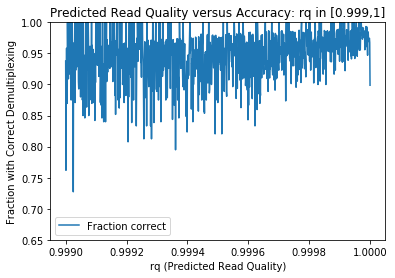

In [26]:
#zoom in
plt.figure();
rq_ax = rq_df.loc[0.999:1].plot(title='Predicted Read Quality versus Accuracy: rq in [0.999,1]')
rq_ax.set_xlabel('rq (Predicted Read Quality)')
rq_ax.set_ylim(0.65, 1)
rq_ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

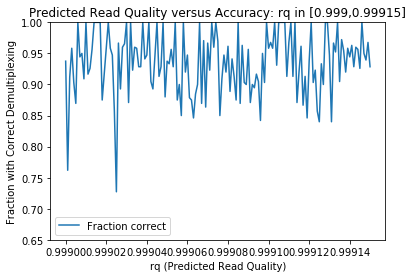

In [27]:
#zoom in
plt.figure();
rq_ax = rq_df.loc[0.999:0.99915].plot(title='Predicted Read Quality versus Accuracy: rq in [0.999,0.99915]')
rq_ax.set_xlabel('rq (Predicted Read Quality)')
rq_ax.set_ylim(0.65, 1)
rq_ax.set_ylabel('Fraction with Correct Demultiplexing')

After the dip between 0.99902 and 0.99904, all the ZMWs with an rq>=0.99904 have an accuracy >= 0.8; depending on our threshold for accuracy, we could keep much of this. 

If we want an accuracy greater than .90, we'll need to constrict the domain further: 

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

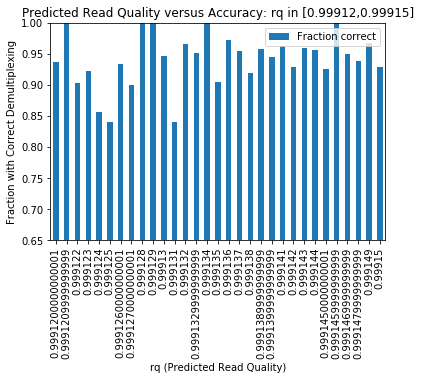

In [28]:
#zoom in
plt.figure();
rq_ax = rq_df.loc[0.99912:0.99915].plot(kind = 'bar',title='Predicted Read Quality versus Accuracy: rq in [0.99912,0.99915]')
rq_ax.set_xlabel('rq (Predicted Read Quality)')
rq_ax.set_ylim(0.65, 1)
rq_ax.set_ylabel('Fraction with Correct Demultiplexing')

For an accuracy >= 0.90, rq must be >= 0.999138

# ZA 
(avg z-score of successfully added subreads)

First: distribution of zmws

In [29]:
#df_combo.sort_values(by='za')['za']
#za range: -43 to 43

In [30]:
za_zmw_count =df_combo.groupby('za').size()
za_zmw_df = pd.DataFrame.from_dict(za_zmw_count)

<Figure size 432x288 with 0 Axes>

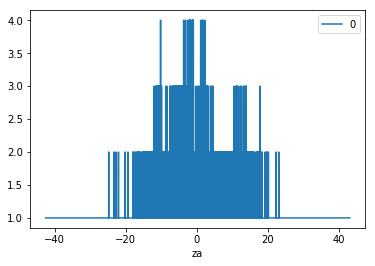

In [31]:
plt.figure()
ax = za_zmw_df.plot()

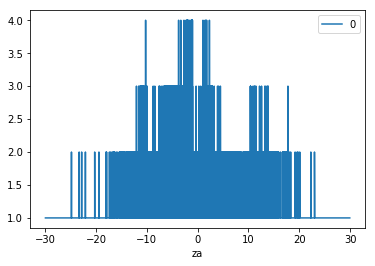

In [32]:
za_zmw_df.loc[-30:30].plot()

It appears most zmws are between a za of -25 and 25. We could focus on that region, but many just have two zmws in their za bin. We could restrict further, although the highest number is four. Let's look at three: 

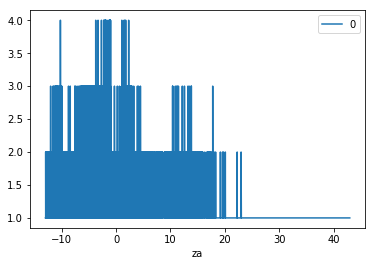

In [33]:
za_zmw_df.loc[-13:55].plot()

In [34]:
#separate based on za
za_percent_correct_dict = percent_correct(df_combo.groupby('za'))

In [35]:
za_df = pd.DataFrame.from_dict(za_percent_correct_dict, 'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

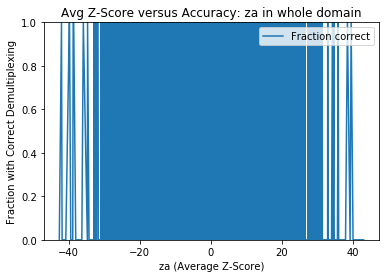

In [36]:
#look at accuracy: full view
plt.figure();
za_ax = za_df.plot(title='Avg Z-Score versus Accuracy: za in whole domain')
za_ax.set_xlabel('za (Average Z-Score)')
za_ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
za_ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

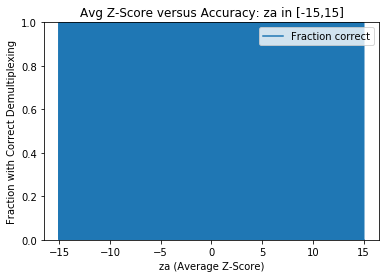

In [37]:
#zoom in
plt.figure();
za_ax = za_df.loc[-15:15].plot(title='Avg Z-Score versus Accuracy: za in [-15,15]')
za_ax.set_xlabel('za (Average Z-Score)')
za_ax.set_ylim(0, 1)
za_ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

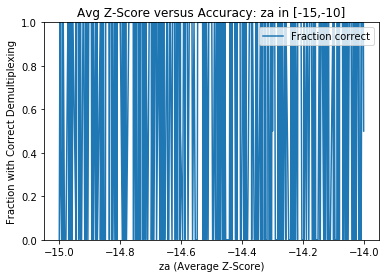

In [38]:
#zoom in
plt.figure();
za_ax = za_df.loc[-15:-14].plot(title='Avg Z-Score versus Accuracy: za in [-15,-10]')
za_ax.set_xlabel('za (Average Z-Score)')
za_ax.set_ylim(0, 1)
za_ax.set_ylabel('Fraction with Correct Demultiplexing')

# ZA Conclusion:
no clear relationship to accuracy; don't use this parameter to filter

# LIMA PARAMETERS

# ScoreLead
(how close first barcode call is to second. too low and get false positives)

In [39]:
score_lead_zmw_count =df_combo.groupby('ScoreLead').size()
score_lead_zmw_df = pd.DataFrame.from_dict(score_lead_zmw_count)

<Figure size 432x288 with 0 Axes>

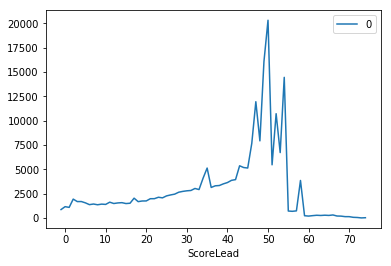

In [40]:
plt.figure()
ax = score_lead_zmw_df.plot()

Big drop off somewhere between 50 and 70. 

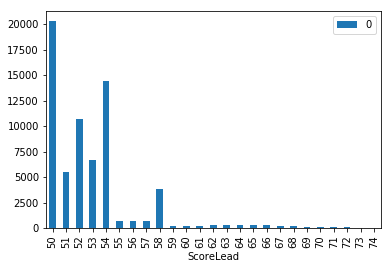

In [41]:
score_lead_zmw_df.loc[50:].plot(kind='bar')

Looks like nearly all zmws lie at ScoreLead <=58. However, the larger the ScoreLead, the lower the chance of false positives. It would be nice to keep as many high ScoreLead zmws as possible.

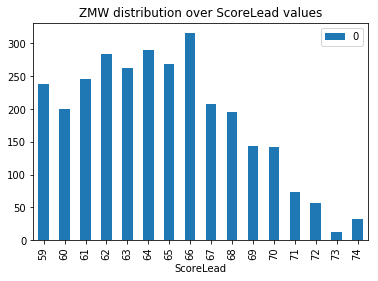

In [42]:
score_lead_zmw_df.loc[59:].plot(kind='bar', title='ZMW distribution over ScoreLead values')

Even the "dropoff" in the quantity of ZMWs in each bin still has a sizable amount, so we probably don't need to exclude ScoreLead values based strictly off of ZMW distribution. 

In [43]:
score_lead_percent_correct_dict = percent_correct(df_combo.groupby('ScoreLead'))

In [44]:
score_lead_df = pd.DataFrame.from_dict(score_lead_percent_correct_dict, 'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

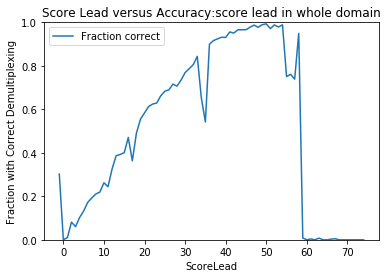

In [45]:
#look at accuracy: full view
plt.figure();
score_lead_ax = score_lead_df.plot(title='Score Lead versus Accuracy:score lead in whole domain')
score_lead_ax.set_xlabel('ScoreLead')
score_lead_ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
score_lead_ax.set_ylabel('Fraction with Correct Demultiplexing')

In [46]:
#df_combo.sort_values(by='ScoreLead')['ScoreLead']
#Range: -1 to 74

A dropoff in accuracy happens in the same general area as the dropoff in amount of ZMWs in each ScoreLead bin; somewhere between ScoreLead of 50 and 60

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

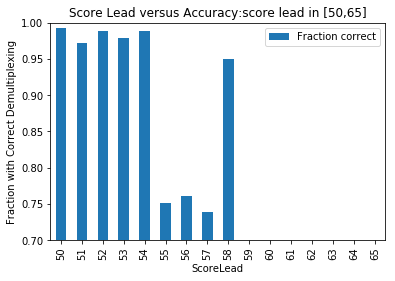

In [47]:
#zoom in to find max ScoreLead
plt.figure();
score_lead_ax = score_lead_df.loc[50:65].plot(kind = 'bar',title='Score Lead versus Accuracy:score lead in [50,65]')
score_lead_ax.set_xlabel('ScoreLead')
score_lead_ax.set_ylim(0.7, 1)
#za_ax.set_xlim(-30,30)
score_lead_ax.set_ylabel('Fraction with Correct Demultiplexing')

In ZMW distribution AND accuracy plot: first minor dropoff at ScoreLead = 54, second larger at ScoreLead = 58

For Accuracy >=.9, we should stick to:

Max ScoreLead <=54

Min: ScoreLead somewhere between 30 and 45


Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

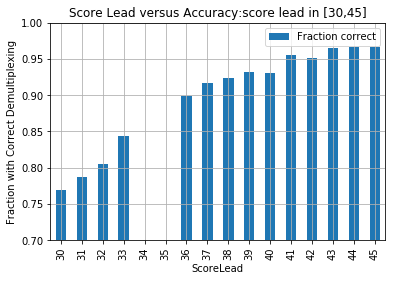

In [48]:
#zoom in to find min ScoreLead
plt.figure();
score_lead_ax = score_lead_df.loc[30:45].plot(kind = 'bar', grid = True, title='Score Lead versus Accuracy:score lead in [30,45]')
score_lead_ax.set_xlabel('ScoreLead')
score_lead_ax.set_ylim(0.7, 1)
#za_ax.set_xlim(-30,30)
score_lead_ax.set_ylabel('Fraction with Correct Demultiplexing')

For accuracy >= .9, want min ScoreLead >=36

# ScoreLead Conclusion:
For accuracy >= 0.9, want ScoreLead in [36,54]

# PassedFilters
(1 if passed Lima filters, 0 if not)

In [49]:
passed_filters_zmw_count =df_combo.groupby('PassedFilters').size()
passed_filters_zmw_df = pd.DataFrame.from_dict(passed_filters_zmw_count)

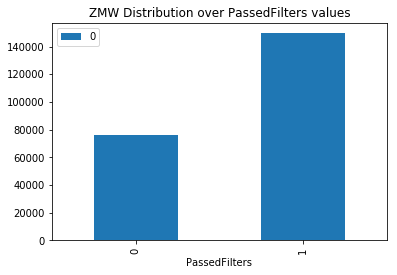

In [50]:
passed_filters_zmw_df.plot(kind = 'bar',title="ZMW Distribution over PassedFilters values")

In [51]:
passed_filters_percent_correct_dict = percent_correct(df_combo.groupby('PassedFilters'))

In [52]:
passed_filters_df = pd.DataFrame.from_dict(passed_filters_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

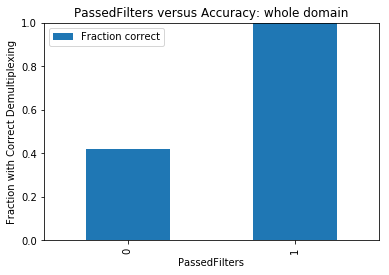

In [53]:
#look at accuracy: full view
plt.figure();
ax = passed_filters_df.plot(kind = 'bar',title='PassedFilters versus Accuracy: whole domain')
ax.set_xlabel('PassedFilters')
ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

# PassedFilters Conclusion:
Only keep those that have PassedFilters=1 (ie those that pass Lima Filters)

# NumBarcodedRegions
(number of barcode regions identified in read)

In [54]:
numBarcoded_zmw_count =df_combo.groupby('NumBarcodedRegions').size()
numBarcoded_zmw_df = pd.DataFrame.from_dict(numBarcoded_zmw_count)

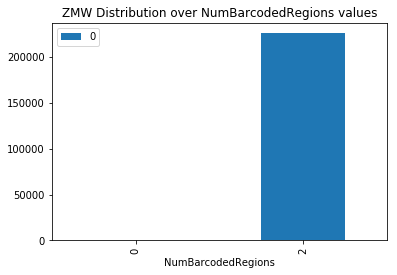

In [55]:
numBarcoded_zmw_df.plot(kind = 'bar',title="ZMW Distribution over NumBarcodedRegions values")

In [56]:
numBarcoded_zmw_count

NumBarcodedRegions
0        31
2    225506
dtype: int64

Most reads have two barcoded regions (good; 5' and 3'). Some have zero, which we obviously don't want. 

In [57]:
numBarcoded_percent_correct_dict = percent_correct(df_combo.groupby('NumBarcodedRegions'))

In [58]:
numBarcoded_df = pd.DataFrame.from_dict(numBarcoded_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

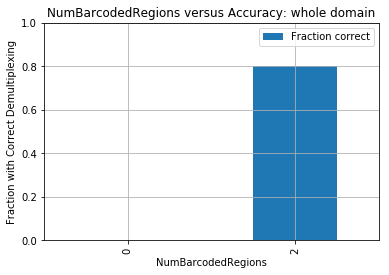

In [59]:
#look at accuracy: full view
plt.figure();
ax = numBarcoded_df.plot(kind = 'bar',grid = True,title='NumBarcodedRegions versus Accuracy: whole domain')
ax.set_xlabel('NumBarcodedRegions')
ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

# NumBarcodedRegions Conclusions:
Want this equal to 2.

# NumBarcodedRegionsPassed
(of barcode regions identified in read, how many passed relevant filters? Intuition would say we want 2 to pass)

In [60]:
barPass_zmw_count =df_combo.groupby('NumBarcodedRegionsPassed').size()
barPass_zmw_df = pd.DataFrame.from_dict(barPass_zmw_count)

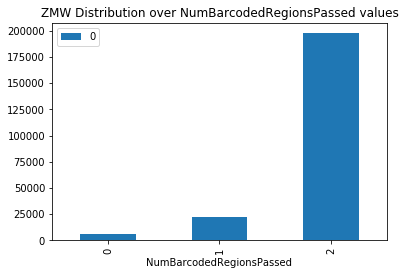

In [61]:
barPass_zmw_df.plot(kind = 'bar',title="ZMW Distribution over NumBarcodedRegionsPassed values")

In [62]:
barPass_percent_correct_dict = percent_correct(df_combo.groupby('NumBarcodedRegionsPassed'))

In [63]:
barPass_df = pd.DataFrame.from_dict(barPass_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

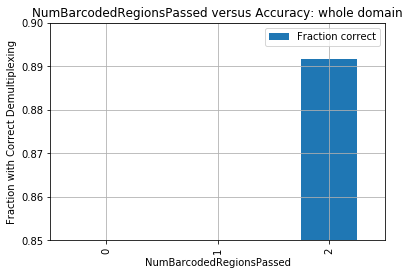

In [64]:
#look at accuracy: full view
plt.figure();
ax = barPass_df.plot(kind = 'bar',grid = True,title='NumBarcodedRegionsPassed versus Accuracy: whole domain')
ax.set_xlabel('NumBarcodedRegionsPassed')
ax.set_ylim(0.85, .9)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

In [65]:
barPass_df

Fraction correct
0          0.072875
1          0.215190
2          0.891649

# NumBarcodedRegionsPassed Conclusion
want equal to 2

# SignalIncrease
(not sure. Reflection of degree of noise? Like the lower it is, the noisier the signal when sequencing?)

In [66]:
signal_zmw_count =df_combo.groupby('SignalIncrease').size()
signal_zmw_df = pd.DataFrame.from_dict(signal_zmw_count)

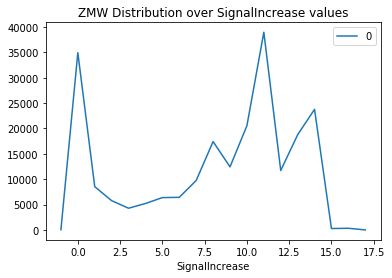

In [67]:
signal_zmw_df.plot(title="ZMW Distribution over SignalIncrease values")

It looks like most ZMWs are between SignalIncrease of [0:15]

In [68]:
signal_percent_correct_dict = percent_correct(df_combo.groupby('SignalIncrease'))

In [69]:
signal_df = pd.DataFrame.from_dict(signal_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

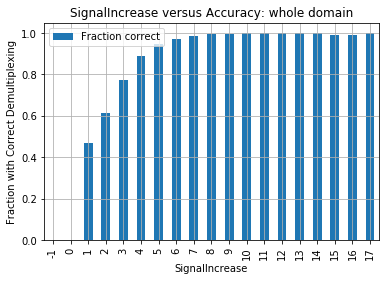

In [71]:
#look at accuracy: full view
plt.figure();
ax = signal_df.plot(kind = 'bar',grid = True,title='SignalIncrease versus Accuracy: whole domain')
ax.set_xlabel('SignalIncrease')
#ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

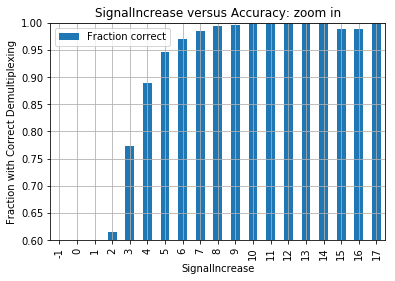

In [72]:
#look at accuracy: zoom in
plt.figure();
ax = signal_df.plot(kind = 'bar',grid = True,title='SignalIncrease versus Accuracy: zoom in')
ax.set_xlabel('SignalIncrease')
ax.set_ylim(0.6, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

# SignalIncrease Conclusion: 
For accuracy >= 0.9: SignalIncrease >= 5

For accuracy >= 0.95: SignalIncrease >= 6

Could easily get higher accuracy with higher min SignalIncrease value

# BarcodeScores
Average of ScoresCombineA and ScoresCombinedB
Expect linear; should be same as way I'm assessing accuracy

In [74]:
#First: need to add column to df_combo
barcode_scores = pd.Series(np.arange(0,225537),index=df_combo.index)

In [84]:
for index,value in barcode_scores.iteritems():
    avg = (df_combo.loc[index,'ScoresCombinedA'] + df_combo.loc[index,'ScoresCombinedB'])/2
    barcode_scores.loc[index] = avg
barcode_scores.head()


ZMW hole number
4194532    100.0
4194565    100.0
4194634    100.0
4194660     54.0
4194723     92.0
dtype: float64

In [90]:
df_combo['AvgScores'] = barcode_scores.values

In [91]:
barcode_zmw_count =df_combo.groupby('AvgScores').size()
barcode_zmw_df = pd.DataFrame.from_dict(barcode_zmw_count)

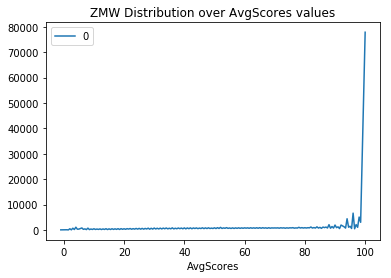

In [92]:
barcode_zmw_df.plot(title="ZMW Distribution over AvgScores values")

(0, 3000)

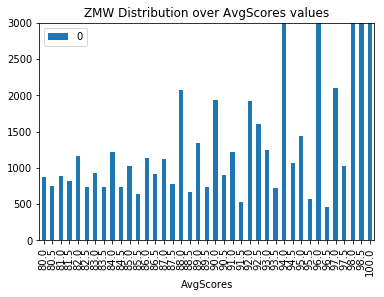

In [98]:
#zoom in: zoom on both axes
ax = barcode_zmw_df.loc[80:100].plot(kind = 'bar',title="ZMW Distribution over AvgScores values")
ax.set_ylim(0,3000) 

(0, 2000)

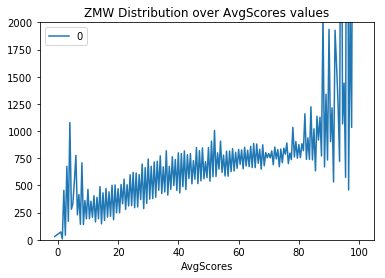

In [96]:
#zoom in: keep whole domain
ax = barcode_zmw_df.plot(title="ZMW Distribution over AvgScores values")
ax.set_ylim(0,2000) 

Although definitely increase in amt of ZMWs as AvgScores value increase, hundreds of ZMWs even in the "low" portions of the graph

In [99]:
barcode_percent_correct_dict = percent_correct(df_combo.groupby('AvgScores'))

In [100]:
barcode_df = pd.DataFrame.from_dict(barcode_percent_correct_dict,
                                           'index',columns = ['Fraction correct'])

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

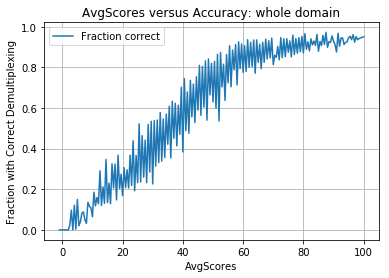

In [102]:
#look at accuracy: full view
plt.figure();
ax = barcode_df.plot(grid = True,title='AvgScores versus Accuracy: whole domain')
ax.set_xlabel('AvgScores')
#ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

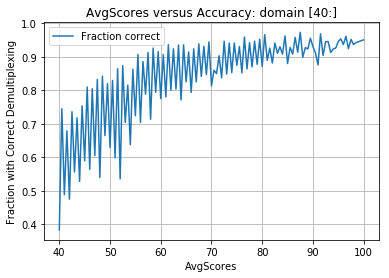

In [103]:
#zoom in
plt.figure();
ax = barcode_df.loc[40:].plot(grid = True,title='AvgScores versus Accuracy: domain [40:]')
ax.set_xlabel('AvgScores')
#ax.set_ylim(0, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

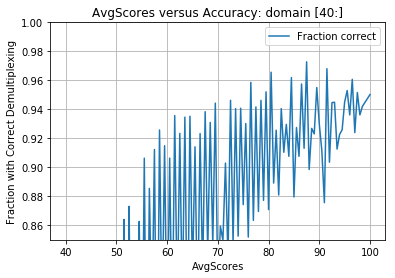

In [106]:
#zoom in
plt.figure();
ax = barcode_df.loc[40:].plot(grid = True,title='AvgScores versus Accuracy: domain [40:]')
ax.set_xlabel('AvgScores')
ax.set_ylim(0.85, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

Text(0,0.5,'Fraction with Correct Demultiplexing')

<Figure size 432x288 with 0 Axes>

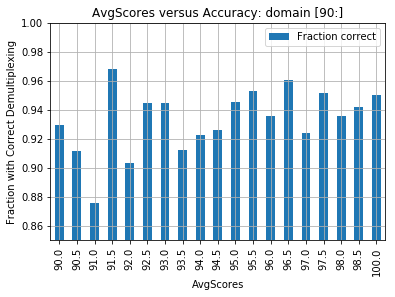

In [108]:
#not steadily above accuracy of 0.9 until past AvgScores=90
#zoom in
plt.figure();
ax = barcode_df.loc[90:].plot(kind = 'bar',grid = True,title='AvgScores versus Accuracy: domain [90:]')
ax.set_xlabel('AvgScores')
ax.set_ylim(0.85, 1)
#za_ax.set_xlim(-30,30)
ax.set_ylabel('Fraction with Correct Demultiplexing')

# BarcodeScores Conclusion:
accuracy >= 0.90: AvgScores >= 91.5

accuracy >= 0.92: AvgScores >= 94.0

In [110]:
#df_combo

np        rq         za  IdxFirst  IdxCombined  \
ZMW hole number                                                    
4194532           53  0.999996   0.351046         3            0   
4194565           10  0.998453  -2.026460         3            0   
4194634           19  0.999807   0.656458         3            0   
4194660            1  0.804675   2.919900         0            3   
4194723            3  0.963705  -0.641072         3            0   
4194784           21  0.999840  -0.179092         3            0   
4194786            1  0.911969  -3.039150         3            0   
4194789            1  0.938065   1.524820         0            3   
4194858            6  0.994842   1.189290         3            0   
4195105            1  0.800443  -1.142200         3            0   
4259993           11  0.999458  -0.002884         3            0   
4260000           44  0.999831   0.011953         3            0   
4260042            2  0.865436   3.161300         0            3   
4260070            1  0.800301   7.636000         0            1   
4260084            2  0.950754  -1.808380         3            0   
4260095            1  0.860520  -0.827592         3            3   
4260098           47  0.999906   1.738260         3            0   
4260117            8  0.996990   3.155800         3            0   
4260122            3  0.960694  -6.023960         0            3   
4260141           24  0.998976  -0.580877         3            0   
4260143           12  0.999244  -0.097722         3            0   
4260218           62  0.999996   0.309279         3            0   
4260240           53  0.999501   1.251520         3            0   
4260250            1  0.780948   5.552910         0            3   
4260253            1  0.807458   9.787880         3            2   
4260258            1  0.906639  -3.240640         3            0   
4260296           18  0.999792  -0.751104         3            0   
4260398            1  0.883909  -6.740190         0            3   
4260437           27  0.999396   0.381302         3            0   
4260489            7  0.995839  -2.690400         3            0   
...              ...       ...        ...       ...          ...   
74908591          61  0.999979   0.033846         3            0   
74908596         110  0.999995   0.646434         3            0   
74908597          41  0.999940   0.715513         3            0   
74908598           1  0.803405  17.437000         3            0   
74908599           9  0.995897  -5.677440         0            0   
74908600          79  0.999961   1.950300         3            0   
74908601          29  0.999946   0.563110         3            0   
74908602           1  0.852845  -5.279250         3            0   
74908603           1  0.919400  -9.587360         0            0   
74908604          26  0.999807  -4.216140         3            0   
74908614          48  1.000000  -0.561890         2            0   
74908615          38  0.999419   0.733221         3            0   
74908618           8  0.996981  -4.466520         3            0   
74908619          20  0.998752  -0.178988         3            3   
74908621          32  0.999124   2.062780         3            0   
74908622           2  0.956108  -1.355040         3            0   
74908628          38  0.999986  -0.531341         3            0   
74908632          18  0.999207  -0.347865         3            0   
74908638          22  0.999449  -0.197947         3            0   
74908639           9  0.996188   0.134630         3            0   
74908640          10  0.998501  -0.335867         3            0   
74908643          22  0.999359   0.977726         3            0   
74908644           7  0.995464  -5.048030         3            0   
74908645           1  0.780523   5.219060         0            0   
74908648          11  0.999069  -0.749147         3            0   
74908649          49  0.999974   0.108415         3            0   
749086